In [1]:
import numpy as np
import pandas as pd

from keras.datasets import cifar10
from keras.models import Sequential
from keras.optimizers import rmsprop
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import cv2

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def load(train_fn: str, test_fn: str, n_lines_train, n_lines_test):
    
    def read_csv(file_name, n_lines, label=True):
        x = np.ndarray(shape=(n_lines, 3072))
        y = []
        with open(file_name, 'r') as f_in:
            f_in.readline()
            for i in range(n_lines):
                line = f_in.readline().split('"')
                x[i] = [int(pix) for pix in line[1].split(',')]
                if label:
                    l_name = line[2].strip(',').strip()
                    y.append(LABELS.index(l_name))
        return x, y
    
    x_train, y_train = read_csv(train_fn, n_lines_train)
    x_test, _ = read_csv(test_fn, n_lines_test, label=False)    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
    
    return (x_train, y_train, x_val, y_val), x_test


def predict(clf,
            X_test: np.array,
            output_fn: str):
    y_pred = clf.predict_classes(X_test)
    y_pred = [LABELS[pred] for pred in y_pred]
    test_df = pd.DataFrame(data={'Category': y_pred})
    test_df.to_csv(output_fn, index_label='Id')
    return y_pred

In [3]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(32, 32, 3)
        image = image.astype(np.uint8)
        plt.imshow(image)
        plt.title(LABELS[labels[idx]] if labels is not None else '?')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [4]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict_classes(subset, verbose=0)
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(32, 32, 3)
#         image = image.astype(np.uint8)
        plt.imshow(image)
        plt.title(LABELS[label])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [5]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [6]:
n_channels = 3
LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
n_lines_train = 90000
n_lines_test = 90000
(x_train, y_train, x_val, y_val), x_test = load('train.csv', 'test.csv', n_lines_train, n_lines_test)

In [8]:
print(x_train.shape, len(y_train)) 
print(x_val.shape, len(y_val))
print(x_test.shape)

(72000, 3072) 72000
(18000, 3072) 18000
(90000, 3072)


In [9]:
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
x_train = x_train[:,:,:,::-1]
x_val = x_val[:,:,:,::-1]
x_test = x_test[:,:,:,::-1]

In [10]:
print(x_train.shape, len(y_train)) 
print(x_val.shape, len(y_val))
print(x_test.shape)

(72000, 32, 32, 3) 72000
(18000, 32, 32, 3) 18000
(90000, 32, 32, 3)


TRAIN


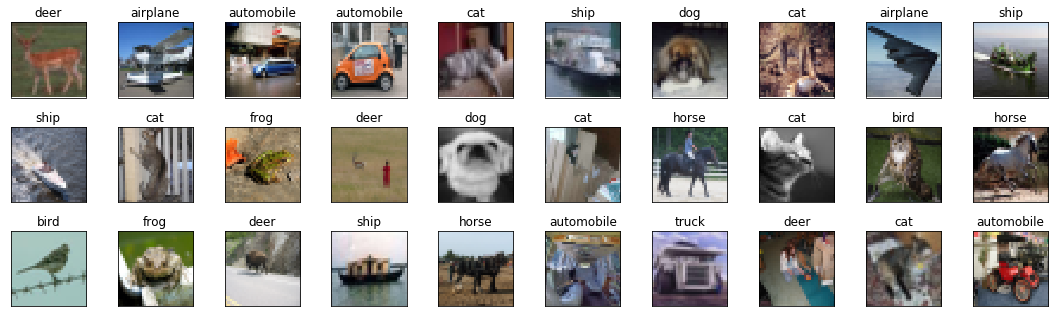

VAL


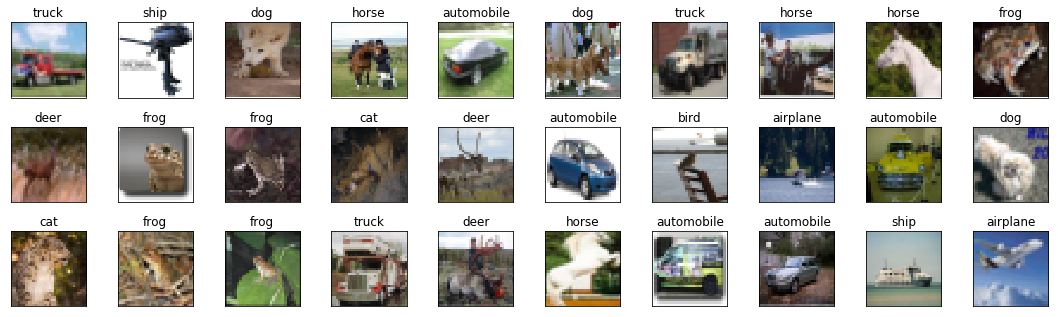

TEST


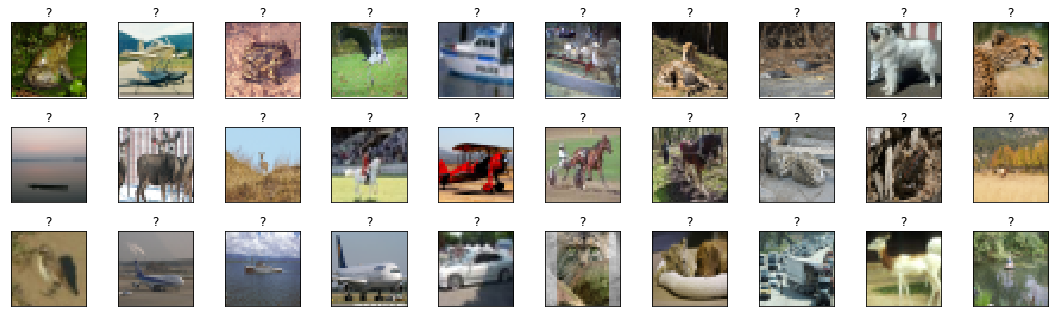

In [11]:
print('TRAIN')
show_random_images(x_train, y_train, 3, 10)
print('VAL')
show_random_images(x_val, y_val, 3, 10)
print('TEST')
show_random_images(x_test, None, 3, 10)

In [12]:
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

In [13]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

In [14]:
def lr_scheduler(epoch):
    lr = 1e-3
    if epoch > 50:
        lr = 5e-4
    if epoch > 100:
        lr = 3e-4
    if epoch > 150:
        lr = 2e-4
    if epoch > 200:
        lr = 1e-4
    if epoch > 250:
        lr = 5e-5
#     if epoch > 100:
#         lr = 3e-4
#     if epoch > 100:
#         lr = 3e-4
    return lr

In [15]:
def build_model():
    model= Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(1e-4),
                     data_format='channels_last', input_shape=(32, 32, n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
        
    model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), 
                 kernel_regularizer=regularizers.l2(1e-4),
                 padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), 
                     kernel_regularizer=regularizers.l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))

    model.add(Dense(10, activation='softmax'))
    
    opt = rmsprop(lr=1e-3)  # , decay=1e-3/300)

    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [16]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2

In [17]:
l_sch = LearningRateScheduler(lr_scheduler)
check = ModelCheckpoint('models/model_epoch_{epoch:02d}_val_acc_{val_acc:.5f}.hdf5',
                         monitor='val_acc',
                         mode='max',
                         save_best_only=True)
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

In [18]:
img_aug_gen = ImageDataGenerator(rotation_range=40,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 horizontal_flip=True,
                                 zoom_range=0.3)

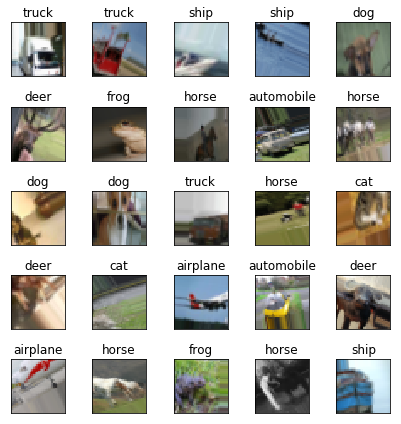

In [19]:
x_batch, y_batch = next(img_aug_gen.flow(x_train, y_train, batch_size=25))

plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_batch[i].reshape(32,32,3))
    plt.title(LABELS[np.argmax(y_batch[i])])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [20]:
history = model.fit_generator(img_aug_gen.flow(x_train, y_train, batch_size=32),
                              steps_per_epoch=x_train.shape[0] // 32,
                              validation_data=(x_val, y_val),
                              callbacks=[tb, l_sch], 
                              epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2250/2250 [==============================] - 27s 12ms/step - loss: 2.0735 - acc: 0.2709 - val_loss: 2.0381 - val_acc: 0.3103
Epoch 2/100
2250/2250 [==============================] - 26s 12ms/step - loss: 1.8455 - acc: 0.3486 - val_loss: 2.1177 - val_acc: 0.2861
Epoch 3/100
2250/2250 [==============================] - 25s 11ms/step - loss: 1.7789 - acc: 0.3810 - val_loss: 1.6220 - val_acc: 0.4294
Epoch 4/100
2250/2250 [==============================] - 24s 11ms/step - loss: 1.7320 - acc: 0.4055 - val_loss: 1.8392 - val_acc: 0.3885
Epoch 5/100
2250/2250 [==============================] - 24s 10ms/step - loss: 1.7053 - acc: 0.4208 - val_loss: 1.7025 - val_acc: 0.4382
Epoch 6/100
2250/2250 [==============================] - 24s 11ms/step - loss: 1.6737 - acc: 0.4395 - val_loss: 1.6421 - val_acc: 0.4490
Epoch 7/100
2250/2250 [==============================] - 24s 11ms/step - loss: 1.6493 - acc: 0.4520 - val_loss: 2.0837 - val_acc: 

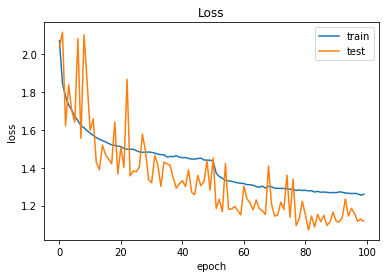

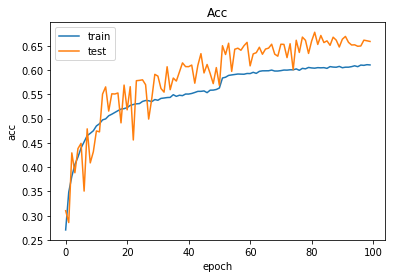

In [21]:
plot_history(history)

In [24]:
acc = model.evaluate(x_train, y_train, verbose=0)[1]
print('Model train acc: %0.2f%%' % (100 * acc))

val_acc = model.evaluate(x_val, y_val, verbose=0)[1]
print('Model val acc: %0.2f%%' % (100 * val_acc))

Model train acc: 67.70%
Model val acc: 65.87%


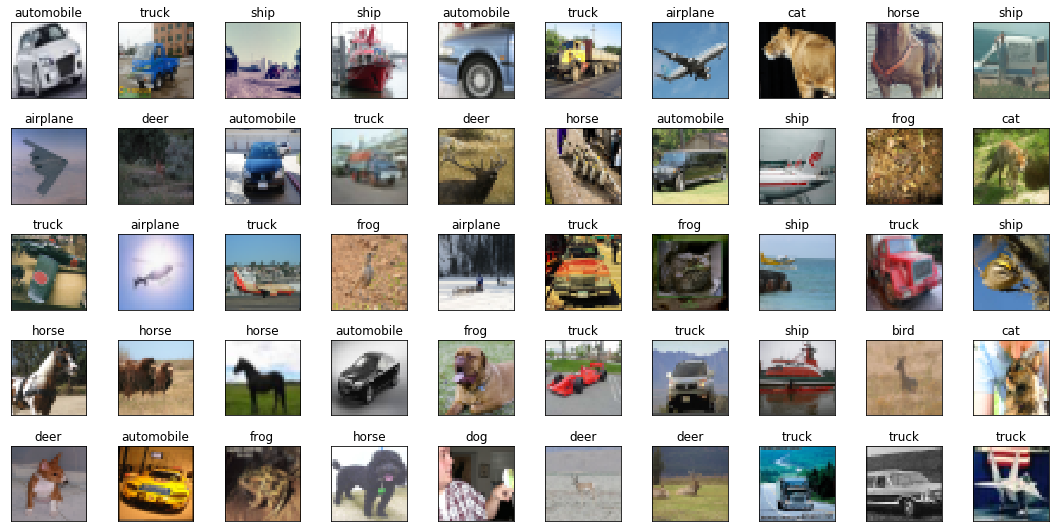

In [25]:
predict_random_images(x_test, model, 5, 10)

In [27]:
history = model.fit_generator(img_aug_gen.flow(x_train, y_train, batch_size=32),
                              steps_per_epoch=x_train.shape[0] // 32,
                              validation_data=(x_val, y_val),
                              callbacks=[tb, l_sch], 
                              epochs=300,
                              initial_epoch=100)

Epoch 101/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.2435 - acc: 0.6143 - val_loss: 1.2311 - val_acc: 0.6300
Epoch 102/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.2176 - acc: 0.6206 - val_loss: 1.0524 - val_acc: 0.6815
Epoch 103/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.2094 - acc: 0.6250 - val_loss: 1.0589 - val_acc: 0.6839
Epoch 104/300
2250/2250 [==============================] - 23s 10ms/step - loss: 1.2069 - acc: 0.6279 - val_loss: 1.0811 - val_acc: 0.6769
Epoch 105/300
2250/2250 [==============================] - 23s 10ms/step - loss: 1.2037 - acc: 0.6250 - val_loss: 1.0470 - val_acc: 0.6854
Epoch 106/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.2074 - acc: 0.6256 - val_loss: 1.1176 - val_acc: 0.6622
Epoch 107/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.1993 - acc: 0.6269 - val_loss: 1.0950 - val_acc: 0.6659
Epoch 108/300
2250/2250 [==

Epoch 160/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.1397 - acc: 0.6413 - val_loss: 0.9858 - val_acc: 0.6979
Epoch 161/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.1330 - acc: 0.6433 - val_loss: 0.9924 - val_acc: 0.6983
Epoch 162/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.1283 - acc: 0.6479 - val_loss: 0.9721 - val_acc: 0.7025
Epoch 163/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.1303 - acc: 0.6458 - val_loss: 1.0209 - val_acc: 0.6933
Epoch 164/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.1285 - acc: 0.6460 - val_loss: 0.9781 - val_acc: 0.7002
Epoch 165/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.1268 - acc: 0.6476 - val_loss: 0.9603 - val_acc: 0.7062
Epoch 166/300
2250/2250 [==============================] - 27s 12ms/step - loss: 1.1222 - acc: 0.6490 - val_loss: 0.9866 - val_acc: 0.6976
Epoch 167/300
2250/2250 [==

Epoch 219/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0780 - acc: 0.6600 - val_loss: 0.9425 - val_acc: 0.7078
Epoch 220/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0786 - acc: 0.6586 - val_loss: 0.9537 - val_acc: 0.7044
Epoch 221/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.0793 - acc: 0.6588 - val_loss: 0.9598 - val_acc: 0.7038
Epoch 222/300
2250/2250 [==============================] - 24s 10ms/step - loss: 1.0804 - acc: 0.6592 - val_loss: 0.9429 - val_acc: 0.7045
Epoch 223/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.0803 - acc: 0.6589 - val_loss: 0.9741 - val_acc: 0.7001
Epoch 224/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0802 - acc: 0.6587 - val_loss: 0.9475 - val_acc: 0.7039
Epoch 225/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0728 - acc: 0.6629 - val_loss: 0.9432 - val_acc: 0.7071
Epoch 226/300
2250/2250 [==

Epoch 278/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0562 - acc: 0.6669 - val_loss: 0.9512 - val_acc: 0.7027
Epoch 279/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0525 - acc: 0.6661 - val_loss: 0.9493 - val_acc: 0.7049
Epoch 280/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0586 - acc: 0.6658 - val_loss: 0.9393 - val_acc: 0.7075
Epoch 281/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0525 - acc: 0.6675 - val_loss: 0.9318 - val_acc: 0.7109
Epoch 282/300
2250/2250 [==============================] - 25s 11ms/step - loss: 1.0518 - acc: 0.6711 - val_loss: 0.9499 - val_acc: 0.7059
Epoch 283/300
2250/2250 [==============================] - 24s 10ms/step - loss: 1.0538 - acc: 0.6656 - val_loss: 0.9291 - val_acc: 0.7123
Epoch 284/300
2250/2250 [==============================] - 24s 11ms/step - loss: 1.0491 - acc: 0.6683 - val_loss: 0.9396 - val_acc: 0.7084
Epoch 285/300
2250/2250 [==

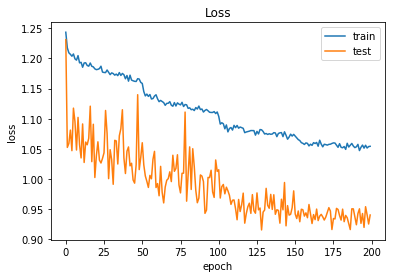

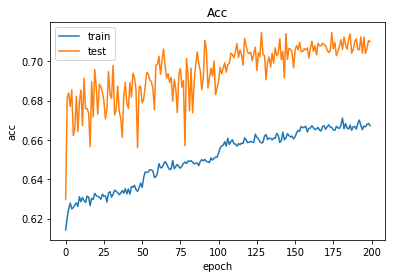

In [28]:
plot_history(history)

In [29]:
acc = model.evaluate(x_train, y_train, verbose=0)[1]
print('Model train acc: %0.2f%%' % (100 * acc))

val_acc = model.evaluate(x_val, y_val, verbose=0)[1]
print('Model val acc: %0.2f%%' % (100 * val_acc))

Model train acc: 73.73%
Model val acc: 70.99%


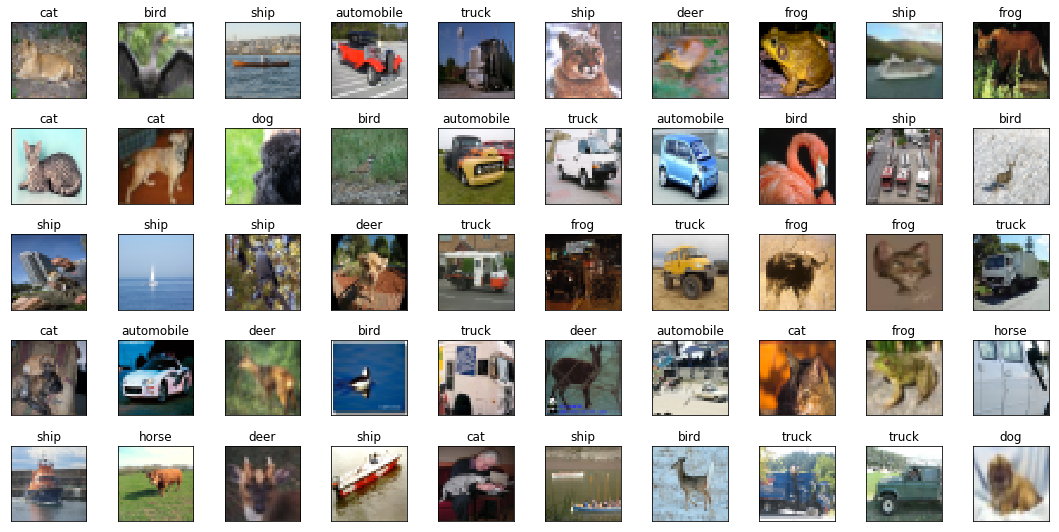

In [30]:
predict_random_images(x_test, model, 5, 10)

In [31]:
y_pred = predict(model, x_test, 'submissions/submission_5_%0.5f.csv' % val_acc)

In [32]:
model.save('model_val_acc_%0.4f.hdf5' % val_acc)

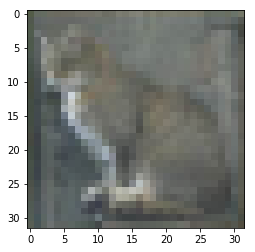

In [45]:
plt.imshow(x_test[12])